In [7]:
import Diagrams.Prelude

We recreate the "diamond theory" by Steven H. Cullinane (see the Recode project
http://recodeproject.com/artwork/v2n1diamond-theory).



In [8]:
{-# LANGUAGE NoMonomorphismRestriction FlexibleContexts TypeFamilies #-}

import System.Random
import Data.List.Split

The idea is to generate a matrix of tiles, where each tile is a square with
random black and white right triangles in it triangle. In practice, each
tile is composed of 4 smaller (square) tiles and each of them has 4 very small
tiles. We note the tiles "large", "medium" and "small" respectively in the code.

We first define the small tile. It is composed of a square split into two right
triangles. The upper left triangle is always white, the lower right triangle is
always black.



In [9]:
side = sqrt 2
triangleRect = polygon ( with
  & polyType .~ PolySides
     [ 135 @@ deg, 90 @@ deg]
     [ 1        , side      ]
  )

When defining each triangle, the enveloppe do not take the linewidth (lw) into
account so we set it to none. This will cause issues later on.



In [13]:
triangleLeft = triangleRect # rotateBy (1/2) # fc white # lc white # lw none

triangleRight = triangleRect # fc black #lc black # lw none

For the small tile, we enforce the old behaviour for the origin of the tile
as we want the triangles to be composed at the point of tangency, enforced by
"align".



In [14]:
smallTile = beside (r2 (1,-1)) (triangleLeft # align (r2 (1, -1)))
                                triangleRight

For interesting results, the small tiles are rotated randomly
 with angles in `\{0, \frac{\pi}{2}, \pi, \frac{3 \pi}{2} \}`.



In [15]:
smallTile' x = smallTile # rotate x'
  where x' = fromIntegral x *pi/2 @@ rad

Now we can create the medium tile, where 4 small tiles are placed in a
matrix-like fashion. The origin must be placed at the center with align



We then create the large tiles as a composition of 4 medium tiles.
For even more interesting results, we use a random number of axis of symmetry
(between 0 and 2). Here, we take list of 16 angles as input, where each angle
corresponds  to a random rotation for the small tiles.
Beware reflectX is actually a reflection in respect to the Y axis, so the
naming convention is inverted.



In [25]:
largeTile angles xSymmetry ySymmetry = createMatrix [a, b, c, d]
  where
    a = mediumTile $ chunks !! 0
    b = if ySymmetry then a # reflectX else mediumTile $ chunks !! 1
    c = if xSymmetry then a # reflectY else mediumTile $ chunks !! 2
    d
      | ySymmetry && xSymmetry = a # rotateBy (-1/2)
      | ySymmetry  = c # reflectX
      | xSymmetry  = b # reflectY
      | otherwise = mediumTile $ chunks !! 3
    chunks = chunksOf 4 angles

-- Needs a list of 16 angles and the number of axes
largeTile' x = largeTile n xSymmetry ySymmetry
  where
    n = fst x
    nbAxes = snd x
    xSymmetry = nbAxes == 1 || nbAxes == 3
    ySymmetry = nbAxes == 2 || nbAxes == 3


createMatrix x = matrix # alignX 0 # alignY 0
  where matrix = (x !! 0 ||| x !! 1 )
                         ===
                 (x !! 2 ||| x !! 3)

mediumTile angles = createMatrix (map smallTile' angles)

Line 3: Use head
Found:
chunks !! 0
Why not:
head chunksLine 23: Use head
Found:
x !! 0
Why not:
head x

Finally, we create an array of large tiles by using `position`. The random
angles and number of axis of symmetries are generated here, at the higher level.
This allows us to only generate two random list. However, they must be split into
chunks accordingly.
As a final note, the bug with the linewidth will most likely appear in the final
results as very fine gapes between the small tiles.



In [21]:
centerPos x = (x-0.5)*4 + (x-1)*d
    where d = 1.5

randInts :: Int -> [Int]
randInts seed = randomRs (0, 3) (mkStdGen seed)

example = position (zip (map p2 pos) (zipWith (curry largeTile') angles nbAxes))
  where
    nb = 10
    pos = [(centerPos x, centerPos y) | x <- [1..nb], y <- [1..nb]]
    angles = take (nb*nb) $ chunksOf 16 $ randInts 15
    nbAxes = take (nb*nb) $ randInts 12

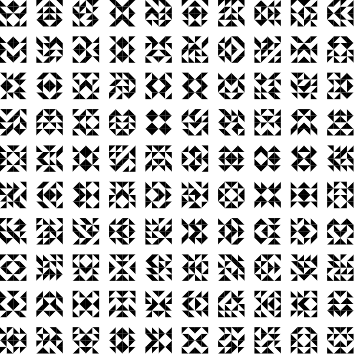

In [22]:
diagram example